In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from aux import compare_clusterings, zscore

%matplotlib inline

In [2]:
import lifelines
lifelines.__version__

'0.25.10'

In [3]:
data_dir = "/home/olya/TUM/DESMOND/DESMOND2/OV_cancer_final/data/"
subt_dir = data_dir+"OVcancer_subtypes/"

In [4]:
subt_dict = {"DIF_consensus":'differentiated',
            "MES_consensus": 'mesenchymal',
            "IMR_consensus":'immunoreactive',
            "PRO_consensus": 'proliferative',
            "NA":"NA"}
subt_dict.update({'DIF': 'differentiated',
 'MES': 'mesenchymal',
 'IMR': 'immunoreactive',
 'PRO': 'proliferative',
 'NA': 'NA'}) 

In [5]:
uke_exprs = pd.read_csv(data_dir+"HH.exprs.tsv.gz", sep ="\t",index_col=0)

uke_subt = pd.read_csv(subt_dir+"HH_166_OVconsensus_subtypes.tsv",sep ="\t",index_col=0)

uke_annot = pd.read_csv(data_dir+"/HH.sample_annotation_v2_166.tsv",sep ="\t",index_col=0)
uke_annot["ConsensusOV_subt"] = uke_subt.loc[uke_annot.index,"consensusOV"]
uke_annot["PFS_time"] = uke_annot["RF_time"] 
uke_annot["PFS_event"] = uke_annot["RF_event"] 
uke_annot["subtype"] = uke_annot["ConsensusOV_subt"].fillna("NA").apply(lambda x: subt_dict[x])
print(set(uke_annot["subtype"].values))
uke_annot.head(3)

{'proliferative', 'mesenchymal', 'differentiated', 'immunoreactive'}


,bevacizumab,standard,age,FIGO_I-IIIB,FIGO_IIIC,FIGO_IV,OP_0,OP_1,OP_2,OS_time,OS_event,RF_time,RF_event,ConsensusOV_subt,PFS_time,PFS_event,subtype
sample_id,,,,,,,,,,,,,,,,,
T0063,0,1,53.0,0,1,0,0,1,0,39.0,1.0,8.0,1.0,DIF_consensus,8.0,1.0,differentiated
T0096,0,1,43.0,0,1,0,1,0,0,61.0,1.0,59.0,1.0,DIF_consensus,59.0,1.0,differentiated
T0294,0,1,45.0,1,0,0,1,0,0,142.0,0.0,142.0,0.0,DIF_consensus,142.0,0.0,differentiated


In [6]:
dasl_exprs = pd.read_csv(data_dir+"DASL.exprs_Kommoss.tsv.gz", sep ="\t",index_col=0)

dasl_subt = pd.read_csv(subt_dir+"DASL_Kommoss_OVconsensus_subtypes.tsv",sep ="\t",index_col=0)

dasl_annot = pd.read_csv(data_dir+"DASL.annotation_Kommoss.tsv.gz",sep ="\t",index_col=0)
dasl_annot["subtype"] = dasl_annot["subtype"].apply(lambda x: x.lstrip().rstrip())
dasl_annot["standard"] = dasl_annot["chemo_only"]
dasl_annot["ConsensusOV_subt"] = dasl_subt.loc[dasl_annot.index,"consensusOV"]
dasl_annot.head(2)

,bevacizumab,chemo_only,is_HGSOC,FIGO_code,FIGO_IV,FIGO_I-IIIB,FIGO_IIIC,FIGO_1,FIGO_2,FIGO_3,...,treatment,age,is_HGSOC_GEO,OS_event_GEO,OS_time_GEO,PFS_event_GEO,PFS_time_GEO,subtype,standard,ConsensusOV_subt
sample_id,,,,,,,,,,,,,,,,,,,,,
X5800701055_A,0,1,1,IV,1,0,0,0,0,0,...,standard,47,0,0,43.594521,0,43.594521,immunoreactive,1,DIF_consensus
X5800701055_B,0,1,1,IV,1,0,0,0,0,0,...,standard,65,1,1,26.169863,1,10.750685,proliferative,1,DIF_consensus


In [7]:
tcga_exprs = pd.read_csv(data_dir+"PanCan.OV.exprs.tsv.gz", sep ="\t",index_col=0)
tcga_annot = pd.read_csv("data/OV.annotation.tsv.gz",sep ="\t",index_col=0)
tcga_subt = pd.read_csv(subt_dir+"TCGA_OVconsensus_subtypes.tsv",sep ="\t",index_col=0)
tcga_subt.index = [x.replace(".","-") for x in tcga_subt.index.values]

shared_samples = sorted(set(tcga_annot.index.values).intersection(set(tcga_subt.index.values)))
tcga_annot.loc[shared_samples,"ConsensusOV_subt"] = tcga_subt.loc[shared_samples,"consensusOV"]
tcga_annot["subtype"] = tcga_annot["ConsensusOV_subt"].fillna("NA").apply(lambda x: subt_dict[x])
tcga_annot = tcga_annot.loc[tcga_annot["subtype"]!="NA",:]
tcga_annot.head(3)

,age,sex,stage,cancer_type,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,stage_2,stage_3,stage_4,ConsensusOV_subt,subtype
sample,,,,,,,,,,,,,,,,,
TCGA-04-1331-01,78.0,1,3.0,OV,1.0,1336.0,1.0,1336.0,1.0,459.0,1.0,459.0,0.0,1.0,0.0,PRO_consensus,proliferative
TCGA-04-1332-01,70.0,1,3.0,OV,1.0,1247.0,1.0,1247.0,NaN,NaN,1.0,393.0,0.0,1.0,0.0,MES_consensus,mesenchymal
TCGA-04-1337-01,78.0,1,3.0,OV,1.0,61.0,1.0,61.0,NaN,NaN,1.0,61.0,0.0,1.0,0.0,MES_consensus,mesenchymal


# Comparing predicted consensusOV vs published subtypes  
### TCGA-OV

In [8]:
tcga_subt_paper= pd.read_csv(data_dir+"TCGA.OV.sampleMap_TCGA_OV_gene_expression_subtype.gz",sep ="\t",index_col=0)
s1 = set(tcga_subt_paper["gene_expression_subtype"].index.values)
s2 = set(tcga_exprs.columns.values)
s3 = set(tcga_annot.index.values)
shared_samples = sorted(s1.intersection(s2).intersection(s3))
print("shared samples (TCGA with subtypes)",len(shared_samples))
print(set(tcga_subt_paper["gene_expression_subtype"].values))

conf_matrix = compare_clusterings(tcga_subt_paper.loc[shared_samples,"gene_expression_subtype"],
                       tcga_subt.loc[shared_samples,"consensusOV"])
conf_matrix.loc[["PRO_consensus","MES_consensus","DIF_consensus","IMR_consensus"],
                ["proliferative","mesenchymal","differentiated","immunoreactive"]]

shared samples (TCGA with subtypes) 305
{'proliferative', 'mesenchymal', 'differentiated', 'immunoreactive'}
correct pairs:87.13 ,incorrect pairs:12.87
ARI:0.66


,proliferative,mesenchymal,differentiated,immunoreactive
PRO_consensus,62,3,0,0
MES_consensus,0,62,9,0
DIF_consensus,15,0,55,2
IMR_consensus,6,4,6,81


In [9]:
s1 = set(dasl_subt.index.values)
s2 = set(dasl_annot.index.values)
shared_samples = s1.intersection(s2)

# consensusOV
conf_matrix = compare_clusterings(dasl_annot.loc[shared_samples,"subtype"],
                       dasl_subt.loc[shared_samples,"consensusOV"])
conf_matrix.loc[["PRO_consensus","MES_consensus","DIF_consensus","IMR_consensus"],
                ["proliferative","mesenchymal","differentiated","immunoreactive"]]

correct pairs:72.43 ,incorrect pairs:27.57
ARI:0.28


,proliferative,mesenchymal,differentiated,immunoreactive
PRO_consensus,59,2,6,1
MES_consensus,12,47,18,11
DIF_consensus,18,3,56,35
IMR_consensus,7,21,5,76


In [10]:
color_dict = {"consensusOV":{
    "MES_consensus":"orange",
    "PRO_consensus":"lime",
    "IMR_consensus": "magenta",
    "DIF_consensus":"cyan"
    },
    "subtype":{"MES":"orange", "mesenchymal":"orange",
    "PRO":"lime", 'proliferative':'lime',
    "IMR": "magenta", 'immunoreactive':'magenta',
    "DIF":"cyan",'differentiated':"cyan"
    },
    "Bentink":{
    'Angiogenic':'violet',
    'nonAngiogenic':'gold'},
}

from aux import plot_subtype_heatmap

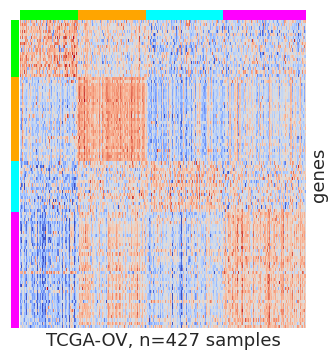

In [11]:
biomarkers = pd.read_excel("tables/S6A-C_subtypes.xlsx",sheet_name="S6C subtype biomarkers")

g = plot_subtype_heatmap(tcga_exprs, tcga_subt, biomarkers,
                         color_dict = color_dict, gene_id = "gene")

g.ax_cbar.set_visible(False)
ax = g.ax_heatmap
ax.set_ylabel("genes")
tmp = ax.set_xlabel("TCGA-OV, n=%s samples"%tcga_exprs.shape[1])
tmp = g.ax_row_colors.tick_params(bottom=False)
tmp = g.ax_col_colors.tick_params(right=False)


not found in expression: ['ENSG00000110042', 'ENSG00000157873', 'ENSG00000276163', 'ENSG00000227816']


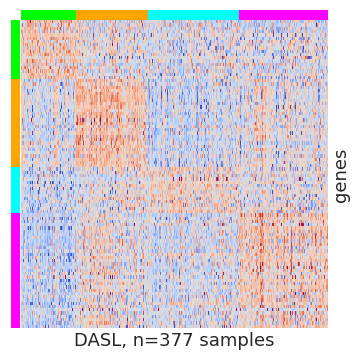

In [12]:
# ConsensusOV preicted  subtypes
g = plot_subtype_heatmap(dasl_exprs, dasl_subt, biomarkers, 
                         color_dict =color_dict, gene_id = "ENSEMBL")

g.ax_cbar.set_visible(False)
ax = g.ax_heatmap
ax.set_ylabel("genes")
tmp = ax.set_xlabel("DASL, n=%s samples"%dasl_exprs.shape[1])
tmp = g.ax_row_colors.tick_params(bottom=False)
tmp = g.ax_col_colors.tick_params(right=False)

not found in expression: ['ENSG00000110042', 'ENSG00000157873', 'ENSG00000276163', 'ENSG00000227816']


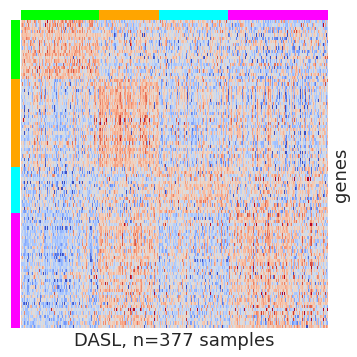

In [13]:
# Kommoss subtypes
a = dasl_annot.loc[:,["subtype"]].copy()
d = dict(zip(["proliferative","mesenchymal","differentiated","immunoreactive"],
              ["PRO_consensus","MES_consensus","DIF_consensus","IMR_consensus"]))
a["consensusOV"] = a["subtype"].apply(lambda x: d[x])
g = plot_subtype_heatmap(dasl_exprs, a, biomarkers,
                         color_dict =color_dict, gene_id = "ENSEMBL")

g.ax_cbar.set_visible(False)
ax = g.ax_heatmap
ax.set_ylabel("genes")
tmp = ax.set_xlabel("DASL, n=%s samples"%dasl_exprs.shape[1])
tmp = g.ax_row_colors.tick_params(bottom=False)
tmp = g.ax_col_colors.tick_params(right=False)

not found in expression: ['ENSG00000129226', 'ENSG00000276163', 'ENSG00000136867', 'ENSG00000227816']


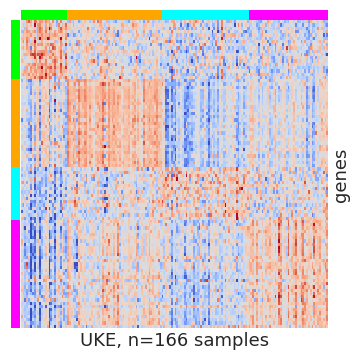

In [14]:
g = plot_subtype_heatmap(uke_exprs.loc[:,uke_annot.index.values], uke_subt.loc[uke_annot.index.values,:], biomarkers,
                         color_dict =color_dict, gene_id = "ENSEMBL")

g.ax_cbar.set_visible(False)
ax = g.ax_heatmap
ax.set_ylabel("genes")
tmp = ax.set_xlabel("UKE, n=%s samples"%uke_exprs.loc[:,uke_annot.index.values].shape[1])
tmp = g.ax_row_colors.tick_params(bottom=False)
tmp = g.ax_col_colors.tick_params(right=False)

#  Prognostic value: survival of subtypes

In [15]:
from aux import plot_KM_prognostic_subytpes

### UKE

In [16]:
surv = "OS" #"OS" # PFS
is_bevac = 1

,n_samples,HR (CI95%),p-value
proliferative,12,0.64 (0.24-1.72),0.38
mesenchymal,21,1.68 (0.77-3.66),0.19
differentiated,7,0.66 (0.13-3.33),0.62
immunoreactive,19,0.89 (0.38-2.10),0.79


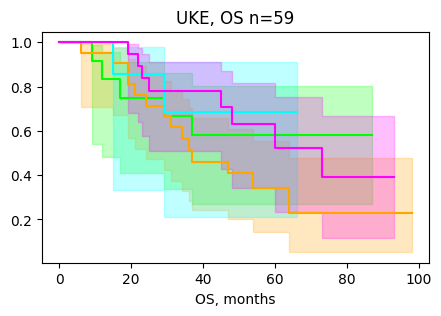

In [17]:
covariates = ["age","FIGO_IIIC","FIGO_IV","OP_1","OP_2"]
surv_data = uke_annot.loc[uke_annot["bevacizumab"]==is_bevac,:]
cohort_name = "UKE"

plot_KM_prognostic_subytpes(surv_data, 
                        surv_event=surv+"_event",surv_time=surv+"_time",
                        xlabel=surv+", months",
                        title = "%s, %s n=%s"%(cohort_name,surv,surv_data.shape[0]),
                        covariates = covariates,
                        subtypes = ["proliferative","mesenchymal","differentiated","immunoreactive"],
                        color_dict = color_dict,
                        cohort_name = "UKE, bevacizumab",
                        figsize=(5,3), plot_legend = False)

### DASL

,n_samples,HR (CI95%),p-value
proliferative,47,0.93 (0.59-1.48),0.77
mesenchymal,39,1.22 (0.74-2.01),0.43
differentiated,42,0.97 (0.57-1.63),0.90
immunoreactive,70,0.94 (0.61-1.46),0.79


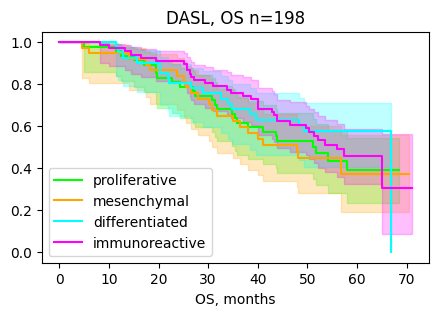

In [18]:
covariates = ["age","FIGO_IIIC","FIGO_IV","OP_1","OP_2"]
surv_data = dasl_annot.loc[dasl_annot["bevacizumab"]==is_bevac,:]
cohort_name = "DASL"

plot_KM_prognostic_subytpes(surv_data, 
                        surv_event=surv+"_event",surv_time=surv+"_time",
                        xlabel=surv+", months",
                        title = "%s, %s n=%s"%(cohort_name,surv,surv_data.shape[0]),
                        covariates = covariates,
                        subtypes = ["proliferative","mesenchymal","differentiated","immunoreactive"],
                        color_dict = color_dict,
                        cohort_name = "DASL, bevacizumab", #standard
                        figsize=(5,3))

### TCGA-OV
(no treatment)

,n_samples,HR (CI95%),p-value
proliferative,86,1.02 (0.75-1.37),0.91
mesenchymal,99,1.14 (0.86-1.50),0.37
differentiated,115,1.21 (0.93-1.58),0.16
immunoreactive,121,0.71 (0.53-0.95),0.02


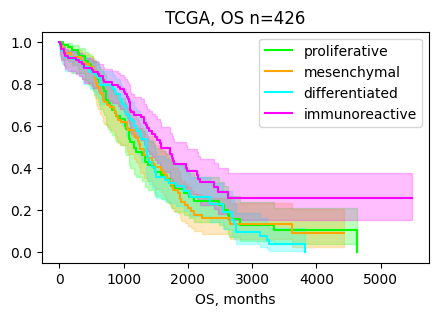

In [19]:
covariates = ["age","stage_2","stage_3","stage_4"]
surv_data = tcga_annot.copy().loc[:,:]
cohort_name = "TCGA"

plot_KM_prognostic_subytpes(surv_data, 
                        surv_event=surv,surv_time=surv+".time",
                        xlabel=surv+", months",
                        title = "%s, %s n=%s"%(cohort_name,surv,surv_data.shape[0]),
                        covariates = covariates,
                        subtypes = ["proliferative","mesenchymal","differentiated","immunoreactive"],
                        color_dict = color_dict,
                        cohort_name = "TCGA-OV",
                        figsize=(5,3))


# Comparing DASL consensusOV predictions vs subtypes in the Kommoss paper 

In [20]:
# consensusOV Verhaak 	Konecny 	Helland 	Bentink
conf_matrix = compare_clusterings(dasl_annot.loc[shared_samples,"subtype"],
                       dasl_subt.loc[shared_samples,"consensusOV"])
conf_matrix 

correct pairs:72.43 ,incorrect pairs:27.57
ARI:0.28


,proliferative,mesenchymal,immunoreactive,differentiated
IMR_consensus,7,21,76,5
PRO_consensus,59,2,1,6
DIF_consensus,18,3,35,56
MES_consensus,12,47,11,18


In [21]:
conf_matrix.sum()

proliferative      96
mesenchymal        73
immunoreactive    123
differentiated     85
dtype: int64

In [22]:
conf_matrix.T.sum()

IMR_consensus    109
PRO_consensus     68
DIF_consensus    112
MES_consensus     88
dtype: int64

In [23]:
for cl in ["consensusOV","Verhaak","Konecny", "Helland","Bentink"]:
    print(cl)
    conf_matrix = compare_clusterings(dasl_annot.loc[shared_samples,"subtype"],
                       dasl_subt.loc[shared_samples,cl])

consensusOV
correct pairs:72.43 ,incorrect pairs:27.57
ARI:0.28
Verhaak
correct pairs:67.80 ,incorrect pairs:32.20
ARI:0.21
Konecny
correct pairs:68.23 ,incorrect pairs:31.77
ARI:0.17
Helland
correct pairs:70.67 ,incorrect pairs:29.33
ARI:0.23
Bentink
correct pairs:49.26 ,incorrect pairs:50.74
ARI:0.05


# Predictive value of subtypes

In [24]:
from aux import plot_KM_predictive_subtypes

## DASL survival analysis

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5661884/

359 **patients** passed QC (acc. to the paper)
380 **samples** passed QC according to Kommoss files; +27 MES and 1 IMR sample

*icon7.qnorm.SLR.qcpassed.380c.29377.csv - 380 QC passed samples quantile normalized and batch corrected by removing array effect wiht simple linear regression.  This is the file Chen clustered to get molecular subgroups used in the paper*

377 samples remain - three removed from 380 due to NA in annotation

Kommos paper : 
1) "Multivariate analysis was then performed using Cox model analyses, adjusting for high risk of progression (suboptimal stage III, inoperable Stage III, and all stage IV patients), age, grade, and histology"
2) 359 samples, but we have 380(337)



### DASL subtypes assigned by Kommoss et. al., 2017

In [25]:
xlim = (0,80)
covariates = ["age","FIGO_IIIC","FIGO_IV","OP_1","OP_2"]
cohort_name="DASL"
subts= ['proliferative','mesenchymal','differentiated', 'immunoreactive']

,bevacizumab,standard,HR (CI95%),p-value
proliferative,47,49,0.55 (0.32-0.97),0.04
mesenchymal,39,34,0.70 (0.36-1.34),0.28
differentiated,42,43,0.54 (0.27-1.09),0.09
immunoreactive,70,53,0.96 (0.56-1.65),0.89


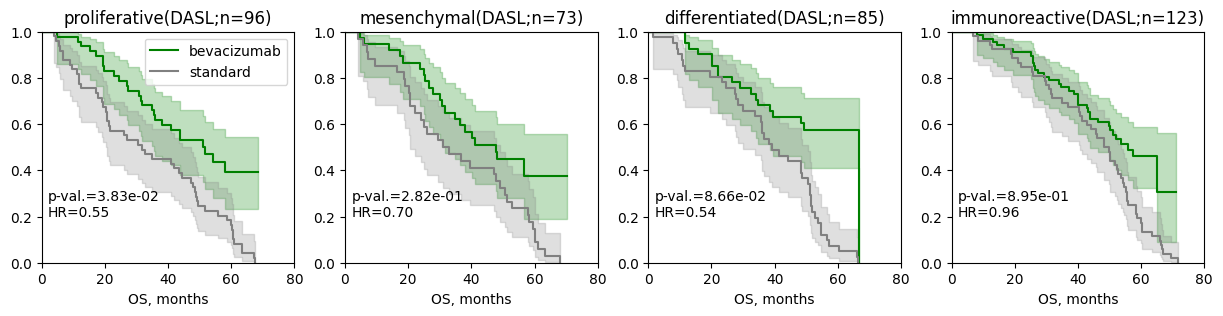

In [26]:
surv = "OS" #


surv_data = dasl_annot.loc[:,["bevacizumab","subtype", surv+"_event",surv+"_time"]+covariates]


plot_KM_predictive_subtypes(surv_data, 
                            covariates = covariates,
                            t1= "bevacizumab", t0="standard",
                            xlabel = surv+", months",
                            xlim = xlim,
                            title = cohort_name,
                            time_col=surv+"_time", event_col=surv+"_event",
                            treatment_col= "bevacizumab",
                            subt_col = "subtype" ,
                            subts=subts,
                           label_pos=(2,0.2))

,bevacizumab,standard,HR (CI95%),p-value
proliferative,47,49,0.50 (0.31-0.83),0.01
mesenchymal,39,34,0.66 (0.38-1.15),0.15
differentiated,42,43,0.72 (0.39-1.32),0.29
immunoreactive,70,53,0.81 (0.51-1.28),0.36


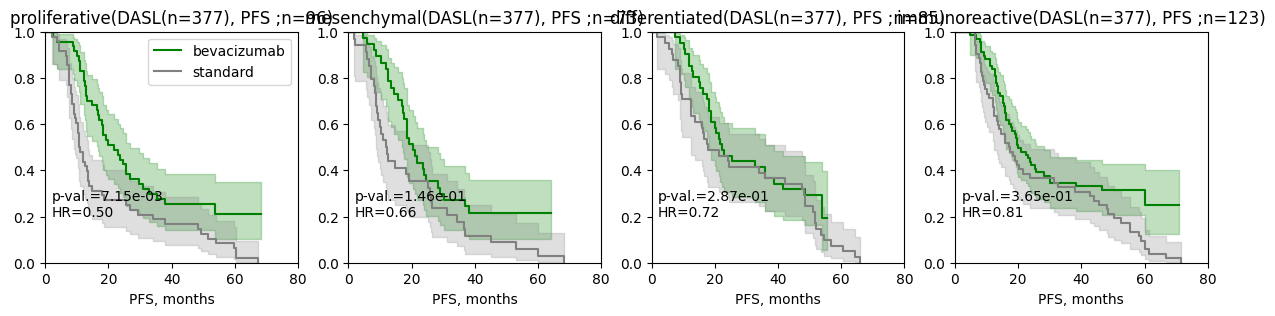

In [27]:
surv = "PFS"
surv_data = dasl_annot.loc[:,["bevacizumab","subtype", surv+"_event",surv+"_time"]+covariates]
plot_KM_predictive_subtypes(surv_data,
                            covariates = covariates,
                            t1= "bevacizumab", t0="standard",
                            xlabel = surv+", months",
                            xlim = xlim,
                            title = "%s(n=%s), %s "%(cohort_name,a.shape[0],surv),
                            time_col=surv+"_time", event_col=surv+"_event",
                            treatment_col= "bevacizumab",
                            subt_col = "subtype" ,
                            subts= ['proliferative','mesenchymal','differentiated', 'immunoreactive'],
                           label_pos=(2,0.2))

### DASL  with re-labelled subtypes

In [28]:
dasl_annot["ConsensusOV_subt"] = dasl_subt.loc[dasl_annot.index,"consensusOV"]
dasl_annot.head(2)

,bevacizumab,chemo_only,is_HGSOC,FIGO_code,FIGO_IV,FIGO_I-IIIB,FIGO_IIIC,FIGO_1,FIGO_2,FIGO_3,...,treatment,age,is_HGSOC_GEO,OS_event_GEO,OS_time_GEO,PFS_event_GEO,PFS_time_GEO,subtype,standard,ConsensusOV_subt
sample_id,,,,,,,,,,,,,,,,,,,,,
X5800701055_A,0,1,1,IV,1,0,0,0,0,0,...,standard,47,0,0,43.594521,0,43.594521,immunoreactive,1,DIF_consensus
X5800701055_B,0,1,1,IV,1,0,0,0,0,0,...,standard,65,1,1,26.169863,1,10.750685,proliferative,1,DIF_consensus


In [36]:
cohort_name="re-labelled DASL"
subts = ['PRO','MES','DIF', 'IMR']
covariates = ["age","FIGO_IIIC","FIGO_IV","OP_1","OP_2"]

,bevacizumab,standard,HR (CI95%),p-value
PRO,32,36,0.60 (0.31-1.16),0.13
MES,44,44,0.86 (0.50-1.48),0.58
DIF,56,56,0.61 (0.33-1.12),0.11
IMR,66,43,0.77 (0.44-1.34),0.35


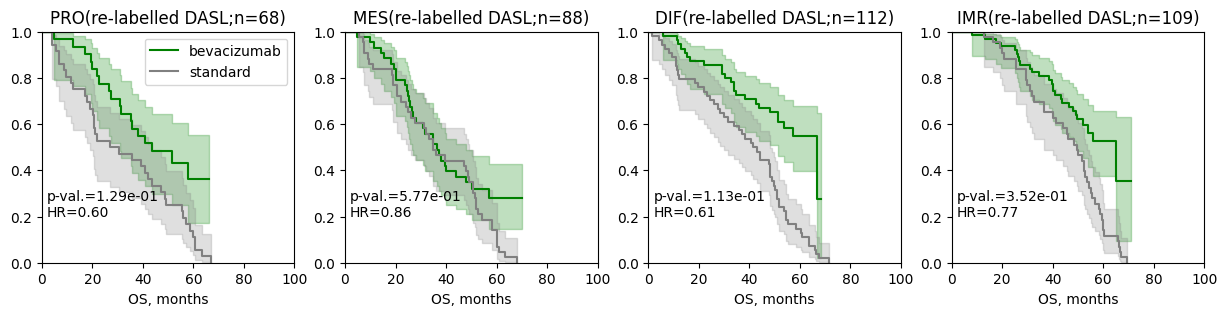

In [37]:
surv = "OS" 
surv_data = dasl_annot.loc[:,["bevacizumab","ConsensusOV_subt", surv+"_event",surv+"_time"]+covariates]

plot_KM_predictive_subtypes(surv_data,
                            covariates = covariates,
                            t1= "bevacizumab", t0="standard",
                            xlabel = surv+", months",
                            xlim = xlim,
                            title = cohort_name,
                            time_col=surv+"_time", event_col=surv+"_event",
                            treatment_col= "bevacizumab",
                            subt_col = "ConsensusOV_subt" ,
                            subts= subts,
                           label_pos=(2,0.2))

,bevacizumab,standard,HR (CI95%),p-value
PRO,32,36,0.51 (0.28-0.93),0.03
MES,44,44,0.83 (0.50-1.37),0.46
DIF,56,56,0.85 (0.51-1.40),0.52
IMR,66,43,0.64 (0.39-1.03),0.07


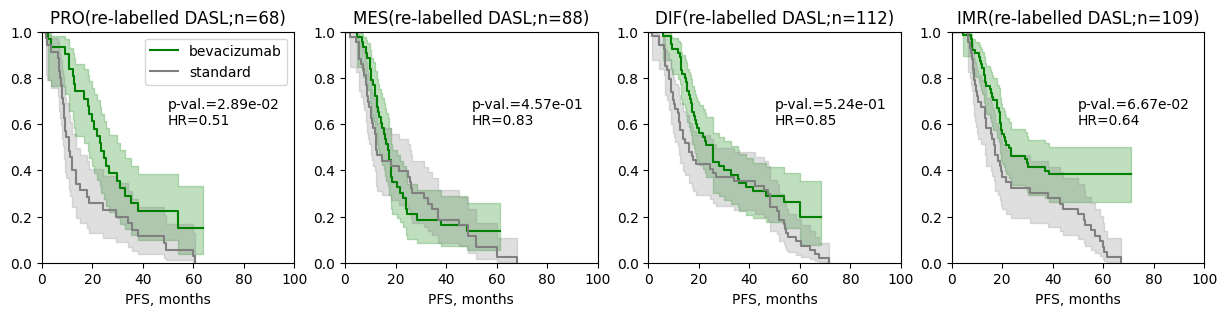

In [41]:
surv = "PFS"
surv_data = dasl_annot.loc[:,["bevacizumab","ConsensusOV_subt", surv+"_event",surv+"_time"]+covariates]


plot_KM_predictive_subtypes(surv_data,
                            covariates = covariates,
                            t1= "bevacizumab", t0="standard",
                            xlabel = surv+", months",
                            xlim = xlim,
                            title =cohort_name,
                            time_col=surv+"_time", event_col=surv+"_event",
                            treatment_col= "bevacizumab",
                            subt_col = "ConsensusOV_subt" ,
                            subts= subts,
                           label_pos=(50,0.6))

# UKE cohort analysis

In [42]:
xlim = (0,100)
cohort_name ="UKE"
covariates = ["age","FIGO_IIIC","FIGO_IV","OP_1","OP_2"]
subts= ['proliferative','mesenchymal','differentiated', 'immunoreactive']

,bevacizumab,standard,HR (CI95%),p-value
proliferative,12,13,0.36 (0.10-1.34),0.13
mesenchymal,21,30,0.71 (0.33-1.53),0.38
differentiated,7,40,0.35 (0.08-1.56),0.17
immunoreactive,19,24,0.49 (0.18-1.31),0.15


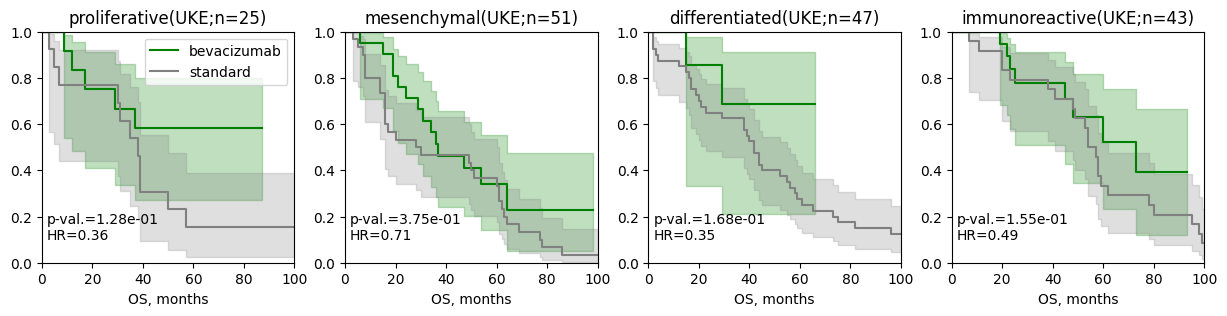

In [43]:
surv = "OS"
surv_data = uke_annot.loc[:,["bevacizumab","subtype", surv+"_event",surv+"_time"]+covariates]

plot_KM_predictive_subtypes(surv_data,
                            covariates = covariates,
                            t1= "bevacizumab", t0="standard",
                            xlabel = surv+", months",
                            xlim = xlim,
                            title = cohort_name,
                            time_col=surv+"_time", event_col=surv+"_event",
                            treatment_col= "bevacizumab",
                            subt_col = "subtype" ,
                            subts=subts,
                           label_pos=(2,0.1))

,bevacizumab,standard,HR (CI95%),p-value
proliferative,12,13,1.13 (0.39-3.25),0.82
mesenchymal,21,30,0.94 (0.47-1.88),0.86
differentiated,7,40,0.74 (0.28-1.96),0.55
immunoreactive,19,24,0.60 (0.29-1.23),0.16


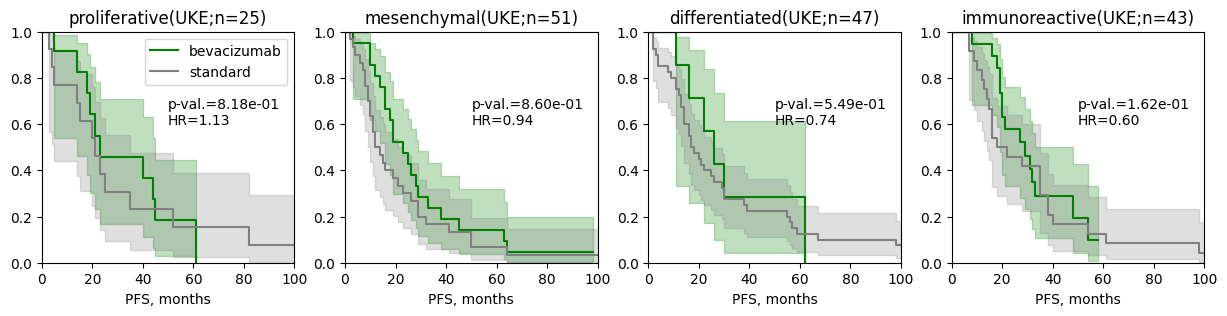

In [45]:
surv = "PFS" 
surv_data = uke_annot.loc[:,["bevacizumab","subtype", surv+"_event",surv+"_time"]+covariates]

plot_KM_predictive_subtypes(surv_data,
                            covariates = covariates,
                            t1= "bevacizumab", t0="standard",
                            xlabel = surv+", months",
                            xlim = xlim,
                            title = cohort_name,
                            time_col=surv+"_time", event_col=surv+"_event",
                            treatment_col= "bevacizumab",
                            subt_col = "subtype" ,
                            subts= ['proliferative','mesenchymal','differentiated', 'immunoreactive'],
                           label_pos=(50,0.6))